An example for using SBINF (Simulation Based Inference with Normalising Flows)

We find an approximation of the posterior $P(\theta|x)$, where $\theta$ are the model parameters and $x$ are the model features.

In [48]:
from sbinf import *
import matplotlib.pyplot as plt

device = torch.device('cuda:0')

### Mock Data 1D

In [49]:
num_samples = 100

def simulation(theta):
    return torch.normal(theta**2, torch.ones(theta.shape) * 0.1)
    
# choose our simulation grid
mock_targets = torch.linspace(-1, 1, num_samples)  # theta

# 'run' the simulations
mock_features = simulation(mock_targets)  # x

# reshape into data vectors
mock_targets, mock_features = mock_targets.unsqueeze(1), mock_features.unsqueeze(1)

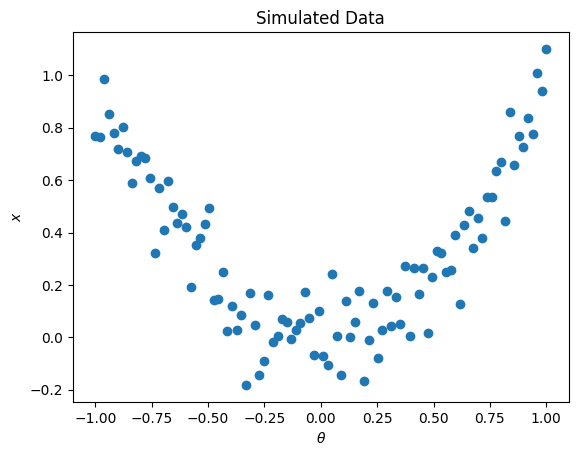

In [50]:
plt.scatter(mock_targets, mock_features)
plt.xlabel('$\\theta$')
plt.ylabel('$x$')
plt.title('Simulated Data')
plt.show()

### Use SBINF to Model the Distribution

Beginning training for 200 epochs

Epoch 1 	| Train Loss: 1.067e+00 	| Val Loss: 1.048e+00
Epoch 21 	| Train Loss: 1.857e-01 	| Val Loss: 3.599e-01
Epoch 41 	| Train Loss: -1.576e-01 	| Val Loss: 1.690e-01
Epoch 61 	| Train Loss: -1.615e-01 	| Val Loss: 4.765e-02
Epoch 81 	| Train Loss: -1.855e-01 	| Val Loss: 2.658e-03
Epoch 101 	| Train Loss: -2.807e-01 	| Val Loss: -7.955e-02
Epoch 121 	| Train Loss: -2.561e-01 	| Val Loss: -3.680e-02
Epoch 141 	| Train Loss: -3.022e-01 	| Val Loss: -1.297e-01
Epoch 161 	| Train Loss: -2.556e-01 	| Val Loss: -1.562e-01
Epoch 181 	| Train Loss: -3.135e-01 	| Val Loss: -1.138e-01

Training complete. Final train loss: -1.667e-01 | Final val loss: -9.068e-02


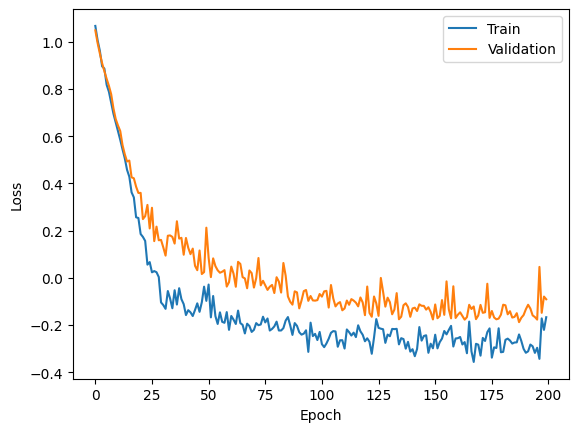

In [57]:
# instantiate model
model = InferenceModel(num_hidden_layers=2, num_flow_layers=4, num_hidden_units=128)

# add the simulatioed features and targets
model.add_simulations(mock_features, mock_targets)

# setup the model
model.setup(device=device)

# train the inference model
model.train_model(num_epochs=200, lr=1e-4)

# show the loss plot
model.show_loss()

### Sample the learned distribution

By using the conditioning (i.e. an 'observed feature'), we can get a posterior distribution given our observation. This is like sampling along a slice of a specific $x$, which is a horizontal slice in our plot above. 

In [58]:
# example observational feature
num_samples = 20000
observed_features = torch.tensor([0.5]).unsqueeze(1).to(device)
observed_features = observed_features.repeat(num_samples, 1)
print(observed_features.shape)
print(mock_features.shape)

samples = model.sample(num_samples, observed_features)[0].cpu().detach().flatten()

torch.Size([20000, 1])
torch.Size([100, 1])


Plotting the distribution along the slice shows a pretty good reconstruction!

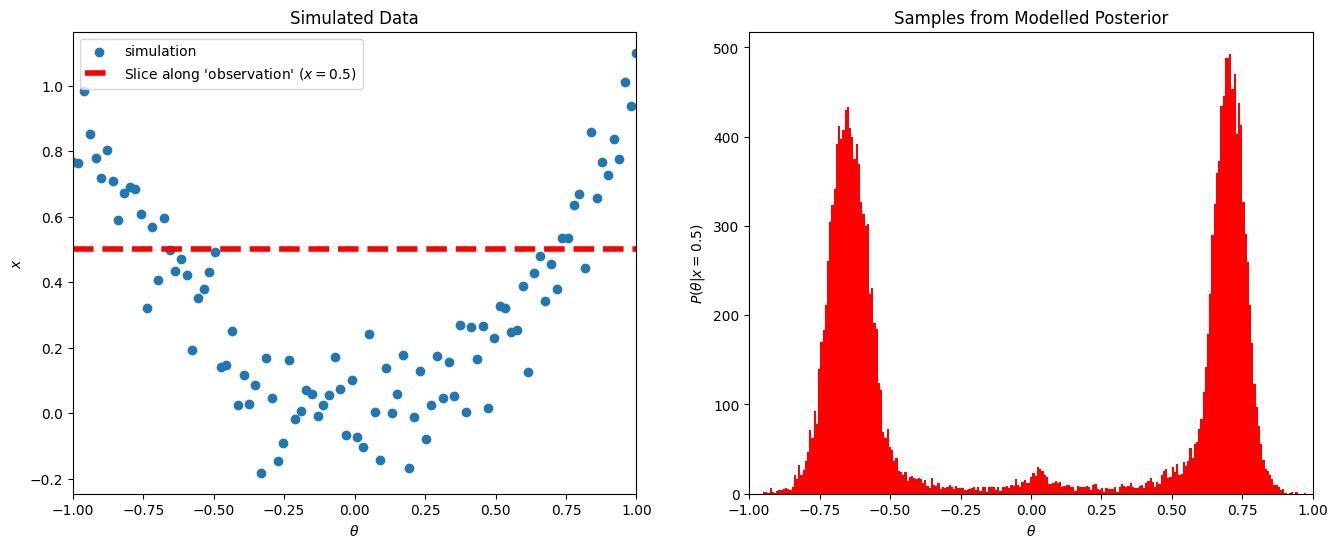

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
axes[0].scatter(mock_targets, mock_features, label='simulation')
axes[0].set_xlabel('$\\theta$')
axes[0].set_ylabel('$x$')
axes[0].set_title('Simulated Data')
axes[0].set_xlim(-1, 1)
axes[0].plot([-1, 1], [0.5, 0.5], c='red', linewidth=4, linestyle='--', label="Slice along 'observation' ($x=0.5$)")
axes[0].legend()

axes[1].set_title('Samples from Modelled Posterior')
axes[1].hist(samples, bins=1000, color='red')
axes[1].set_xlim(-1, 1)
axes[1].set_ylabel('$P(\\theta|x=0.5$)')
axes[1].set_xlabel('$\\theta$')
plt.show()

We can also sample the probability at every point in the 2D space, with our conditioning:

In [62]:
resolution = 100
xspace = torch.linspace(-1, 1, resolution)  # x
yspace = torch.linspace(0, 1, resolution)
xx, yy = torch.meshgrid(xspace, yspace, indexing=None)

In [63]:
results = torch.zeros(resolution, resolution)

for i in range(resolution):
    xpos = xx[i][:, None].to(device)  # get the slice through the meshgrid of all the x points
    ypos = yy[i][:, None].to(device) # and y
    lp = model.log_prob(xpos, ypos)
    results[i] = lp
results = results.detach()

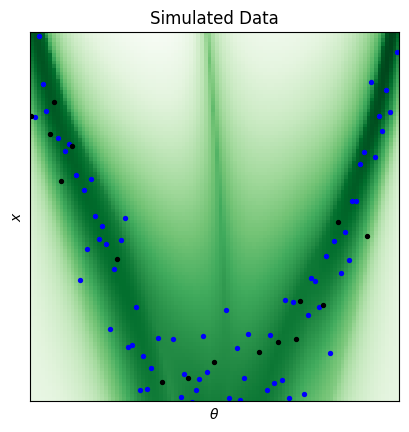

In [64]:
x_train = model.train_targets
y_train = model.train_data

x_val = model.val_targets
y_val = model.val_data

rescale = lambda x, y: ((x + 1) * resolution / 2, y * resolution)

plt.scatter(*rescale(x_train, y_train), c='blue', label='train', s=8)
plt.scatter(*rescale(x_val, y_val), c='black', label='val', s=8)
plt.xlabel('$\\theta$')
plt.ylabel('$x$')
plt.title('Simulated Data', )
plt.imshow(results.T, origin='lower', cmap='Greens')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()